# Реализация линейной регрессии со всеми текущими оптимизациями 

In [51]:
import numpy as np

In [52]:
def get_gradient(f):
    def gradient(x):
        delta = 1e-9

        n = len(x)
        xd = np.copy(x)
        ans = np.zeros(n)

        for i in range(n):
            xd[i] += delta
            ans[i] = np.divide(f(xd) - f(x), delta)
            xd[i] -= delta

        return ans

    return gradient

In [53]:
def get_gradient_descent_Adam (f, gradient):
    def gradient_descent_Adam(
        x0
        , initial_lr=1.0
        , num_iterations=1000
        , eps=1e-6
        , eps_Adam=1e-8
        , minimum=0.0
        , apply_min=False
        , apply_value=True
        , save_history=False):

        B1 = 0.9
        B2 = 0.999

        x = np.copy(x0)
        if save_history:
            points = [x.copy()]
        value = 0.0
        G = eps_Adam
        moment = 0.0
        if apply_value:
            value = f(x)
        for i in range(1, num_iterations):
            if apply_value:
                if apply_min and abs(value - minimum) < eps:
                    break
            else:
                if apply_min and abs(f(x) - minimum) < eps:
                    break

            grad_x = gradient(x)
            moment = moment*B1 + (1 - B1)*grad_x
            G = G*B2 + (1 - B2) * (grad_x.dot(grad_x))

            moment_more = moment / (1 - B1 ** i)
            G_more = G / (1 - B2 ** i)
            new_x = x - initial_lr * (moment_more) / (np.math.sqrt(G_more + eps_Adam))

            if apply_value:
                new_value = f(new_x)
                if new_value < value:
                    x = new_x
                    value = new_value
            else:
                x = new_x
            if save_history:
                points.append(x.copy())

        if save_history:
            return points
        else:
            return x
        
    return gradient_descent_Adam

In [54]:
def mse_loss(x, X, y):
    # print("X -", self.X.shape)

    b = x[-1]
    w = np.delete(x, -1)

    # print("x -", x)
    # print("b -", b)
    # print("w -", w)
    
    y_pred = np.dot(X, w) + b
    mse = np.mean((y - y_pred) ** 2)
    return mse

class Minibatch:
    def get_mse_loss(self):
        def mse_loss_all(x):
            return mse_loss(x, self.X, self.y)

        return mse_loss_all

    def get_mse_loss_minibatch(self):
        if self.batch_size:
            indices = np.random.choice(self.X.shape[0], self.batch_size, replace=False)
            X_batch = self.X[indices, :]
            y_batch = self.y[indices]
            
            def mse_loss_minibatch(x):
                return mse_loss(x, X_batch, y_batch)

            return mse_loss_minibatch
        else:
            return self.get_mse_loss()

    def __init__(self, X, y, batch_size=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size

        if self.batch_size and self.batch_size > X.shape[0]:
            self.batch_size = X.shape[0]

        self.f = self.get_mse_loss()
        self.gradient = get_gradient(self.get_mse_loss_minibatch())
        self.gradient_descent = get_gradient_descent_Adam(self.f, self.gradient)

    # def get_loss_history(self, results):
    #     loss_history = []

    #     for i in range(len(results)):
    #         loss_history.append(self.f(results[i]))

    #     return loss_history

In [55]:
class Get_Model_LinearRegression:
    def __init__(self, batch_size=None):
        self.coef_ = []
        self.intercept_ = None
        self.batch_size = batch_size

    def fit(self, X_train, y_train, epsilon=24, learning_rate=5e-1, max_epochs=4000, apply_min=True):
        minibatch = Minibatch(X_train, y_train, self.batch_size)
        x0 = np.zeros(X_train.shape[1] + 1, dtype=float)

        results = minibatch.gradient_descent(x0, num_iterations=max_epochs, initial_lr=learning_rate, eps=epsilon, apply_min=apply_min)

        self.coef_ = results[:-1]
        self.intercept_ = results[-1] 

    def predict(self, X_test):
        y_pred = []

        for i in range(len(X_test)):
            y = self.intercept_ + sum([self.coef_[j] * float(X_test[i][j]) for j in range(len(self.coef_))])
            y_pred.append(y)
        return y_pred

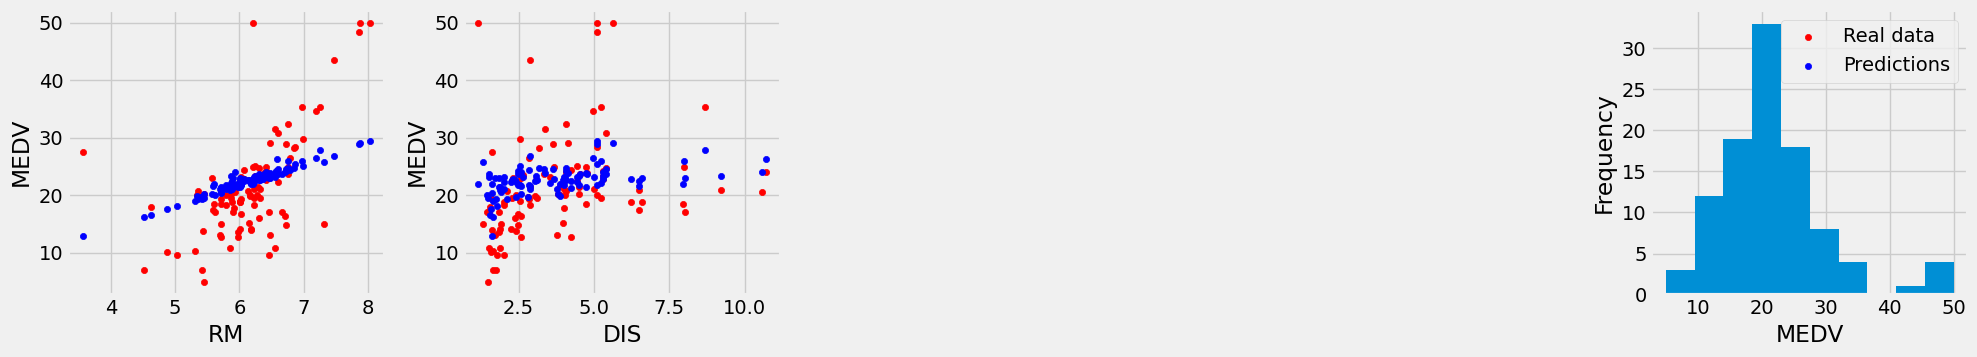

MSE: 53.42568163642429
R^2: 0.27147244647634516


(53.42568163642429, 0.27147244647634516)

In [56]:
from sklearn.datasets import fetch_openml
from helper import train_test_print_model

boston = fetch_openml(name='boston', version=1, as_frame=True , parser='liac-arff')
model = Get_Model_LinearRegression(batch_size=200)

boston.feature_names = ['RM', 'DIS']
train_test_print_model(model, boston, X=boston.data[boston.feature_names].values, print_result=True, view_graphics=True)